In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)
replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total
shape of loaded dataframe (692500, 12)
[1 1 3 3 3 0 1 0 1 1]
[3 3 1 3 1 1 2 0 3 3]


,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No


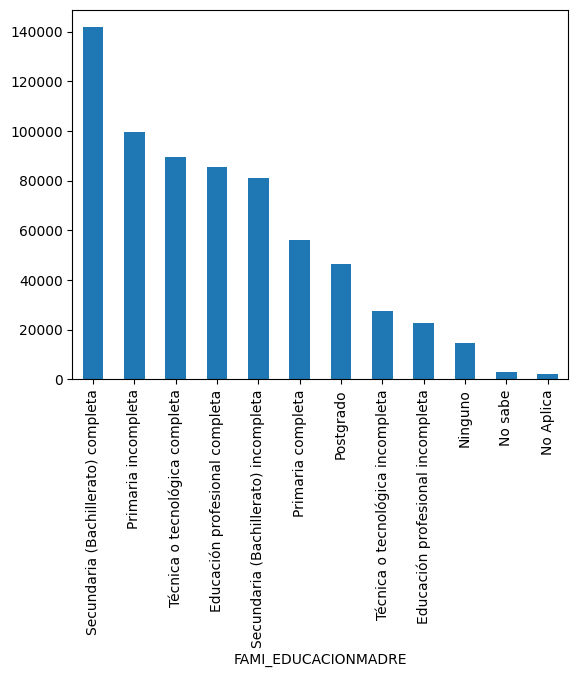

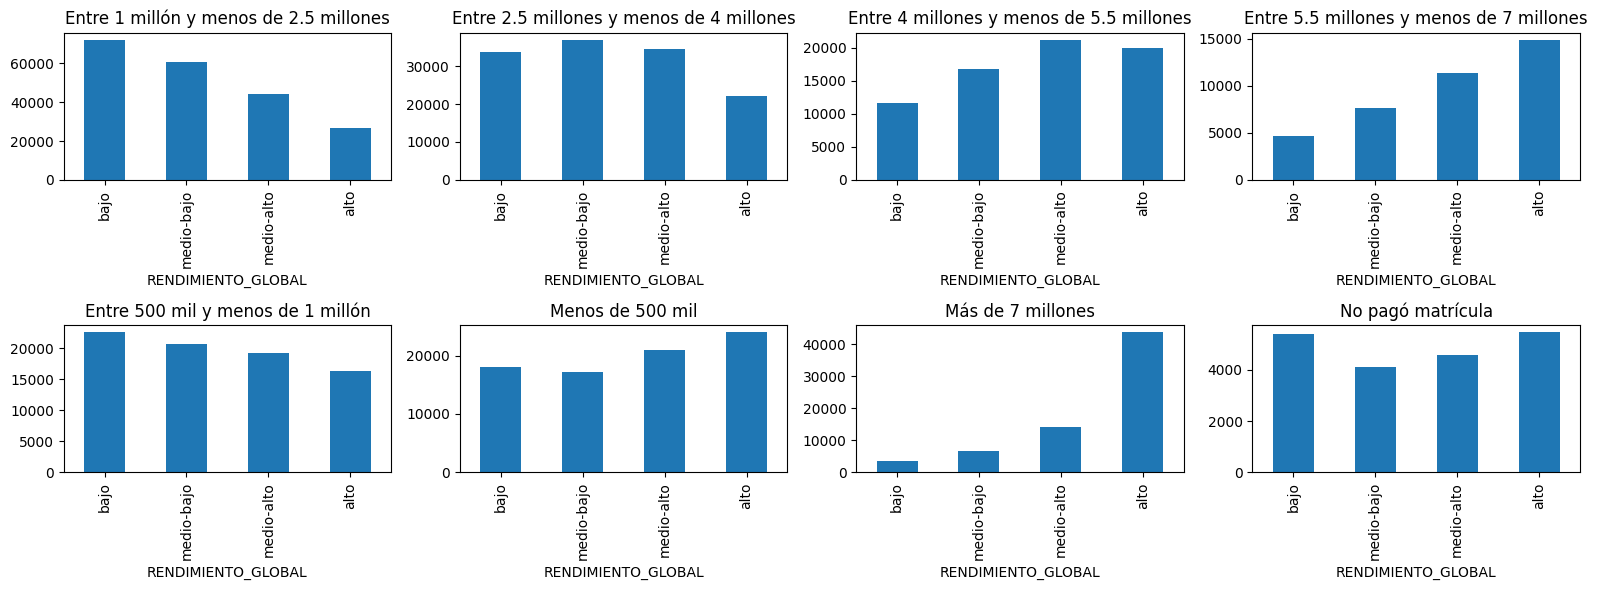

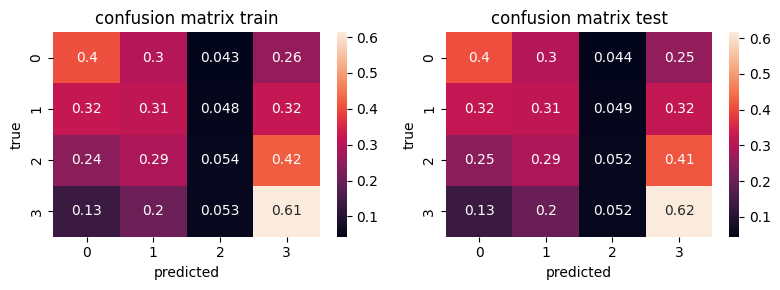

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

!unzip udea*.zip > /dev/null

!wc *.csv

import pandas as pd
import numpy as np

# Cargar los datos
z = pd.read_csv("train.csv")
print("shape of loaded dataframe", z.shape)

z.head()

# Seleccionar las columnas relevantes
z = z[['FAMI_EDUCACIONMADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
z.head()

# Analizar las categorías en las columnas
z.FAMI_EDUCACIONMADRE.value_counts().plot(kind='bar')

from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts().index)
for ax, ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.ESTU_VALORMATRICULAUNIVERSIDAD == ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

# Reemplazar los valores nulos
sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

# Reemplazar valores nulos
z.FAMI_EDUCACIONMADRE.values[z.FAMI_EDUCACIONMADRE.isna()] = 'no info'
z.ESTU_VALORMATRICULAUNIVERSIDAD.values[z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

# Mapeo de valores para ESTU_VALORMATRICULAUNIVERSIDAD
cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Menos de 500 mil': 0.250,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 4 millones y menos de 5.5 millones': 4.75,
        'Más de 7 millones': 7.75,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'No pagó matrícula': 0,
        'no info': -1}

# Transformación de columna ESTU_VALORMATRICULAUNIVERSIDAD
z.ESTU_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.ESTU_VALORMATRICULAUNIVERSIDAD]]
z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts()

# Limpiar la columna FAMI_EDUCACIONMADRE
z = z.copy()
z.FAMI_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.FAMI_EDUCACIONMADRE.values]

# Verificar los valores únicos de la columna
z.FAMI_EDUCACIONMADRE.value_counts()

# Crear la codificación one-hot para la columna FAMI_EDUCACIONMADRE
x = z.FAMI_EDUCACIONMADRE.values
FAMI_EDUCACIONMADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONMADRE_onehot_vals = {val: np.eye(len(FAMI_EDUCACIONMADRE_vals))[i] for i, val in enumerate(FAMI_EDUCACIONMADRE_vals)}
FAMI_EDUCACIONMADRE_onehot_enc = np.r_[[FAMI_EDUCACIONMADRE_onehot_vals[i] for i in z.FAMI_EDUCACIONMADRE]]
FAMI_EDUCACIONMADRE_df = pd.DataFrame(FAMI_EDUCACIONMADRE_onehot_enc, columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in FAMI_EDUCACIONMADRE_onehot_vals])

# Concatenar los resultados one-hot y eliminar la columna original
z = pd.concat([FAMI_EDUCACIONMADRE_df, z], axis=1).drop('FAMI_EDUCACIONMADRE', axis=1)

# Mapeo para la columna RENDIMIENTO_GLOBAL
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'alto': 3, 'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2}
z[y_col] = [rmap[i] for i in z[y_col]]

# Preparar las variables de entrada y salida
z = z[sorted(z.columns)]
X = z[[c for c in z.columns if c != y_col]].values
y = z[y_col].values
X.shape, y.shape

# Dividir los datos en conjunto de entrenamiento y prueba
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

# Entrenar el modelo Gaussiano
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(Xtr, ytr)

# Predicciones
preds_tr = gnb.predict(Xtr)
preds_ts = gnb.predict(Xts)

print(preds_tr[:10])
print(preds_ts[:10])

# Evaluar el rendimiento del modelo
np.mean(preds_tr == ytr), np.mean(preds_ts == yts)

# Matriz de confusión
from sklearn.metrics import confusion_matrix

cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# Normalizar por clase
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1, 1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1, 1)

# Mostrar las matrices de confusión
import seaborn as sns
for ax, i in subplots(2, usizex=4):
    if i == 0:
        sns.heatmap(cm_tr, annot=True)
        plt.title("confusion matrix train")
    if i == 1:
        sns.heatmap(cm_ts, annot=True)
        plt.title("confusion matrix test")
    plt.ylabel("true")
    plt.xlabel("predicted")

# Cargar los datos de prueba
zt = pd.read_csv("test.csv")
zt.head()

In [3]:
zt = pd.read_csv("test.csv")
zt

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Primaria incompleta,Si
296782,296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,No
296783,296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No
296784,296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Educación profesional completa,No


In [4]:
zt_ids = zt['ID'].values
zt = zt[['FAMI_EDUCACIONMADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,FAMI_EDUCACIONMADRE,ESTU_VALORMATRICULAUNIVERSIDAD
0,Primaria completa,Menos de 500 mil
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) completa,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones


In [5]:
zt.FAMI_EDUCACIONMADRE.values[zt.FAMI_EDUCACIONMADRE.isna()] = 'no info'
zt.ESTU_VALORMATRICULAUNIVERSIDAD.values[zt.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'

In [6]:
zt = zt.copy()
zt.ESTU_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in zt.ESTU_VALORMATRICULAUNIVERSIDAD]]

In [7]:
zt.FAMI_EDUCACIONMADRE = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_EDUCACIONMADRE.values]
FAMI_EDUCACIONMADRE_onehot_enc = np.r_[[FAMI_EDUCACIONMADRE_onehot_vals[i] for i in zt.FAMI_EDUCACIONMADRE]]
FAMI_EDUCACIONMADRE_df = pd.DataFrame(FAMI_EDUCACIONMADRE_onehot_enc, columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in FAMI_EDUCACIONMADRE_onehot_vals])
zt = pd.concat([FAMI_EDUCACIONMADRE_df, zt], axis=1).drop('FAMI_EDUCACIONMADRE', axis=1)
zt.shape

(296786, 12)

In [8]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data.shape

(296786, 12)

In [10]:
preds_test_data = gnb.predict(X_test_data)

In [11]:
# inverse mapping
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]

In [12]:
# create dataframe

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,alto
2,499179,medio-bajo
3,782980,bajo
4,785185,medio-bajo
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,alto
296784,963852,alto
